In [3]:
import warnings
warnings.filterwarnings("ignore")
import os
if os.getcwd().split(os.sep)[-1] == 'notebooks':
    os.chdir('..') # set/ ccwd as the parent directory to make imports easier

import pandas as pd
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

In [22]:
df = pd.read_csv('data/PairedImageSets.csv')
# diff = df[df['difference'] == "Arctic animal (Penguins vs Seals)"]
differences = df['group_name'].unique()
[d for d in differences if 'ski' in d]
df[df['group_name'] == 'People snowboarding on a slope']

,group_name,path,difference,difficulty
1900,People snowboarding on a slope,./data/VisDiffBench/easy/10_b/000001.jpg,Snow activity (Skiing vs Snowboarding),easy
1901,People snowboarding on a slope,./data/VisDiffBench/easy/10_b/000002.jpg,Snow activity (Skiing vs Snowboarding),easy
1902,People snowboarding on a slope,./data/VisDiffBench/easy/10_b/000003.jpg,Snow activity (Skiing vs Snowboarding),easy
1903,People snowboarding on a slope,./data/VisDiffBench/easy/10_b/000004.jpg,Snow activity (Skiing vs Snowboarding),easy
1904,People snowboarding on a slope,./data/VisDiffBench/easy/10_b/000005.jpg,Snow activity (Skiing vs Snowboarding),easy
...,...,...,...,...
1995,People snowboarding on a slope,./data/VisDiffBench/easy/10_b/000096.jpg,Snow activity (Skiing vs Snowboarding),easy
1996,People snowboarding on a slope,./data/VisDiffBench/easy/10_b/000097.jpg,Snow activity (Skiing vs Snowboarding),easy
1997,People snowboarding on a slope,./data/VisDiffBench/easy/10_b/000098.jpg,Snow activity (Skiing vs Snowboarding),easy
1998,People snowboarding on a slope,./data/VisDiffBench/easy/10_b/000099.jpg,Snow activity (Skiing vs Snowboarding),easy


# Visualize Images

Board game (Chess vs Checkers)


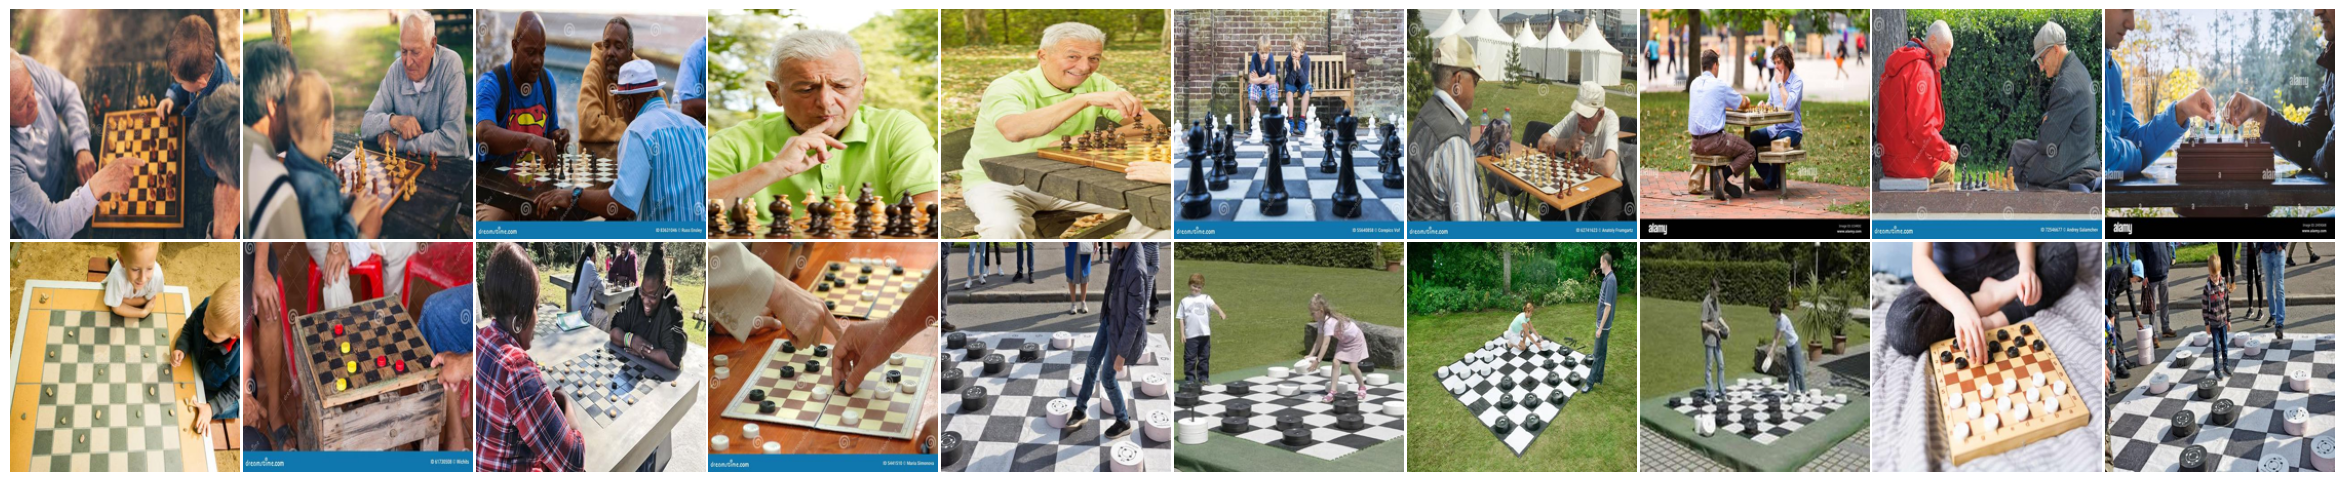

In [2]:
df = pd.read_csv('data/PairedImageSets.csv')
# # randomly pick a difference
diff_choice = df.sample(1).difference.values[0]
df = df[df['difference'] == diff_choice]
df.head()
(group_a, group_b) = df['group_name'].unique()
group_a = df[df['group_name'] == group_a].path.values[:10]
group_b = df[df['group_name'] == group_b].path.values[:10]

fig = plt.figure(figsize=(30., 10.))
# set fig title
# fig.suptitle(diff_choice, fontsize=20)
print(diff_choice)
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(2, 10),  # creates 2x2 grid of axes
                 axes_pad=0.03,  # pad between axes in inch.
                 )

for ax, im in zip(grid, list(group_a) + list(group_b)):
    # Iterating over the grid returns the Axes.
    ax.imshow(Image.open(im).convert("RGB").resize((224, 224)))
    ax.axis('off')

# Compute Benchmark Results
Reads Acc@1 and Acc@5 from WandB project

In [4]:
import wandb
api = wandb.Api()

# read in project runs
project = 'clipinvariance/PairedImageSets' # REPLACE WITH YOUR PROJECT NAME
runs = api.runs(project)

def get_relevant_summary_metrics(run, summary_keys = ['acc@1', 'acc@5'], config_keys = ['group1', 'group2']):
    summary = run.summary
    config = run.config
    # get summary metrics of interest
    metrics = {k: summary[k] for k in summary_keys}
    # get config metrics of interest
    metrics.update({k: config['data'][k] for k in config_keys})
    metrics.update({'proposer': config['proposer']['method'], 'ranker': config['ranker']['method']})
    return metrics

summary = pd.DataFrame([get_relevant_summary_metrics(run) for run in runs if run.state == 'finished'])

In [5]:
df = pd.read_csv("data/PairedImageSets.csv")
summary['group_name'] = summary['group1']
merged_results = summary.merge(df, on=['group_name'], how='inner').sort_values('acc@1', ascending=False).drop_duplicates(['group_name', 'proposer', 'ranker'])
print("PairedImageSets Results")
merged_results.groupby(['difficulty', 'proposer'])[['acc@1', 'acc@5']].mean()

PairedImageSets Results


acc@1  acc@5
difficulty proposer                 
easy       LLMProposer   0.78   0.97
           VLMProposer   0.87   0.98
hard       LLMProposer   0.61   0.86
           VLMProposer   0.60   0.75
medium     LLMProposer   0.69   0.87
           VLMProposer   0.73   0.86

In [7]:
merged_results

,acc@1,acc@5,group1,group2,proposer,ranker,group_name,path,difference,difficulty
20450,1.0,1.0,Porcelain tea cups on a tray,Glass tea cups on a tray,LLMProposer,CLIPRanker,Porcelain tea cups on a tray,./data/VisDiffBench/medium/32_a/000051.jpg,Material (Porcelain vs Glass),medium
24581,1.0,1.0,People eating with chopsticks,People eating with forks,VLMProposer,CLIPRanker,People eating with chopsticks,./data/VisDiffBench/medium/18_a/000082.jpg,Eating utensil (Chopsticks vs Forks),medium
24709,1.0,1.0,Leather jackets on hangers,Denim jackets on hangers,VLMProposer,CLIPRanker,Leather jackets on hangers,./data/VisDiffBench/medium/17_a/000010.jpg,Material (Leather vs Denim),medium
24803,1.0,1.0,Leather jackets on hangers,Denim jackets on hangers,LLMProposer,CLIPRanker,Leather jackets on hangers,./data/VisDiffBench/medium/17_a/000004.jpg,Material (Leather vs Denim),medium
24276,1.0,1.0,Pearl necklaces on display,Gold necklaces on display,VLMProposer,CLIPRanker,Pearl necklaces on display,./data/VisDiffBench/medium/19_a/000077.jpg,Material (Pearl vs Gold),medium
...,...,...,...,...,...,...,...,...,...,...
25996,0.0,0.5,Hardcover books on a table,Paperback books on a table,LLMProposer,CLIPRanker,Hardcover books on a table,./data/VisDiffBench/medium/12_a/000097.jpg,Book binding (Hardcover vs Paperback),medium
26275,0.0,0.5,Laptop computers on a desk,Desktop computers on a desk,LLMProposer,CLIPRanker,Laptop computers on a desk,./data/VisDiffBench/medium/11_a/000076.jpg,Computer type (Laptop vs Desktop),medium
7040,0.0,0.5,Football players in defensive formation,Football players in offensive formation,VLMProposer,CLIPRanker,Football players in defensive formation,./data/VisDiffBench/hard/27_a/000041.jpg,Formation (Defensive vs Offensive),hard
7712,0.0,1.0,Alpine lakes in summer,Alpine lakes in early spring,LLMProposer,CLIPRanker,Alpine lakes in summer,./data/VisDiffBench/hard/25_a/000013.jpg,Season (Summer vs Early Spring),hard


In [5]:
import wandb
api = wandb.Api()

# read in project runs
project = 'clipinvariance/ImageNetStar'
runs = api.runs(project)

summary_star = pd.DataFrame([get_relevant_summary_metrics(run) for run in runs if run.state == 'finished'])
summary_star['dataset'] = 'ImageNetStar'

project = 'clipinvariance/ImageNetR'
runs = api.runs(project)

summary_r = pd.DataFrame([get_relevant_summary_metrics(run) for run in runs if run.state == 'finished'])
summary_r['dataset'] = 'ImageNetR'

summary = pd.concat([summary_star, summary_r])

In [6]:
summary_r.drop_duplicates(['group1', 'proposer', 'ranker'], inplace=True)
summary_r.groupby(['proposer', 'ranker'])[['acc@1', 'acc@5']].mean()

,,acc@1,acc@5
proposer,ranker,,
LLMProposer,CLIPRanker,0.928571,1.000000
VLMProposer,CLIPRanker,0.892857,0.964286


In [10]:
summary['group_name'] = summary['group1']
merged_results = summary.drop_duplicates(['group_name', 'proposer', 'ranker'])
summary

,acc@1,acc@5,group1,group2,proposer,ranker,dataset,group_name
0,1.0,1.0,in the snow,base,LLMProposer,CLIPRanker,ImageNetStar,in the snow
1,1.0,1.0,in the fog,base,LLMProposer,CLIPRanker,ImageNetStar,in the fog
2,1.0,1.0,embroidery,base,LLMProposer,CLIPRanker,ImageNetStar,embroidery
3,1.0,1.0,at night,base,LLMProposer,CLIPRanker,ImageNetStar,at night
4,1.0,1.0,on the road,base,LLMProposer,CLIPRanker,ImageNetStar,on the road
...,...,...,...,...,...,...,...,...
37,1.0,1.0,graphic,imagenet,LLMProposer,CLIPRanker,ImageNetR,graphic
38,0.5,1.0,graffiti,imagenet,LLMProposer,CLIPRanker,ImageNetR,graffiti
39,1.0,1.0,deviantart,imagenet,LLMProposer,CLIPRanker,ImageNetR,deviantart
40,1.0,1.0,cartoon,imagenet,LLMProposer,CLIPRanker,ImageNetR,cartoon


In [ ]:
vlm_proposer = summary[summary['proposer'] == 'VLMProposer']
vlm_proposer[['acc@1', 'acc@5']].mean()

acc@1    0.861111
acc@5    0.902778
dtype: float64

In [ ]:
project = 'clipinvariance/ImageNetR'
runs = api.runs(project)

summary_r = pd.DataFrame([get_relevant_summary_metrics(run) for run in runs])
summary_r['dataset'] = 'ImageNetR'

In [ ]:
summary

,acc@1,acc@5,group1,group2,proposer
0,1.0,1.0,videogame,imagenet,VLMProposer
1,0.5,0.5,toy,imagenet,VLMProposer
2,1.0,1.0,tattoo,imagenet,VLMProposer
3,1.0,1.0,sticker,imagenet,VLMProposer
4,0.5,1.0,sketch,imagenet,VLMProposer
5,1.0,1.0,sculpture,imagenet,VLMProposer
6,1.0,1.0,painting,imagenet,VLMProposer
7,1.0,1.0,origami,imagenet,VLMProposer
8,1.0,1.0,graphic,imagenet,VLMProposer
9,1.0,1.0,graffiti,imagenet,VLMProposer
